# Volume 3: Gibbs Sampling and LDA
    <Name>
    <Class>
    <Date>

In [1]:
import numpy as np
from scipy import stats
from scipy.special import gammaln
from matplotlib import pyplot as plt

## Problem 1

Write a function that accepts data $y$, prior parameters $\nu$, $\tau^2$, $\alpha$, and $\beta$, and an integer $n$. Use Gibbs sampling to generate $n$ samples of $\mu$ and $\sigma^2$ for the data in `examscores.npy`.

Test your sampler with priors $\nu=80$, $\tau^{2} = 16$, $\alpha = 3$, and $\beta = 50$, collecting $1000$ samples.
Plot your samples of $\mu$ and your samples of $\sigma^{2}$ versus the number of samples.

In [4]:
def gibbs(y, nu, tau2, alpha, beta, n_samples):
    """ Gibbs sampler for the exam scores problem, assuming the
    following likelihood and priors.
        y_i    ~ N(mu, sigma2),
        mu     ~ N(nu, tau2),
        sigma2 ~ IG(alpha, beta),

    Paramet===\δεσγηω
        y ((N,) ndarray): the exam scores.
        nu (float): The prior mean parameter for mu.
        tau2 (float > 0): The prior variance parameter for mu.
        alpha (float > 0): The prior alpha parameter for sigma2.
        beta (float < 0): The prior beta parameter for sigma2.
        n_samples (int): the number of samples to draw.

    Returns:
        ((n_samples, 2) ndarray): The mu and sigma2 samples (as columns).
    """
    # initialize
    N = len(y)
    samples = np.empty((n_samples, 2))
    # initialize mu & sigma^2
    mu = stats.norm.rvs(nu, scale=np.sqrt(tau2))
    sig = stats.invgamma.rvs(alpha, scale=beta)

    for i in range(n_samples):
        # calculate the * posteriors
        sig_star = 1.0 / ((1 / tau2) + (N / sig))
        mu_star = (sig_star**2)*((nu/tau2) + (np.sum(y)/sig))
        alpha_star = alpha + N/2
        beta_star = beta + np.sum((y-mu)**2)/2

        # 
        mu = stats.norm.rvs(mu_star, scale=np.sqrt(sig_star))
        sig = stats.invgamma.rvs(alpha_star, scale=beta_star)
        samples[i, :] = [mu, sig]
    return samples

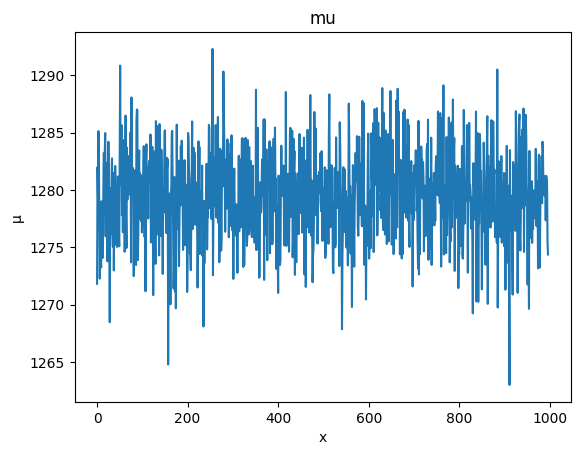

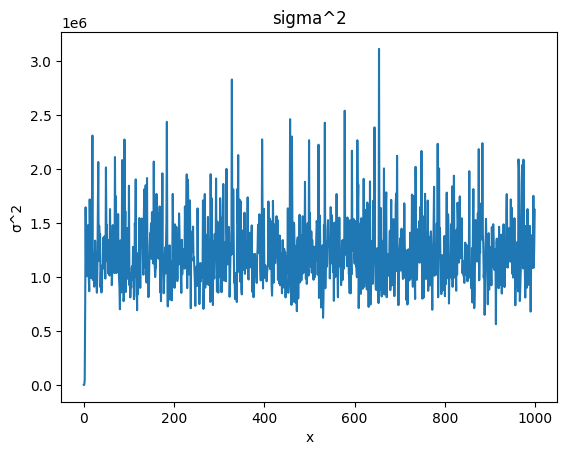

In [26]:
υ,τ_2 = 80, 16
α, β = 3, 50
n_samples = 1000

# load data & draw samples
y = np.load('examscores.npy')
samples = gibbs(y, υ, τ_2, α, β, n_samples)
mus, sigs = samples[3:, 0], samples[:, 1]

# plot mu
plt.plot(mus)
plt.title('mu')
plt.ylabel('μ')
plt.xlabel('x')
plt.show()

# plot sigma^2
plt.plot(sigs)
plt.title('sigma^2')
plt.ylabel('σ^2')
plt.xlabel('x')
plt.show()

## Problem 2

Plot the kernel density estimators for the posterior distributions of $\mu$ and $\sigma^2$.

Next, use your samples of $\mu$ and $\sigma^2$ to draw samples from the posterior predictive distribution.
Plot the kernel density estimator of your sampled scores.

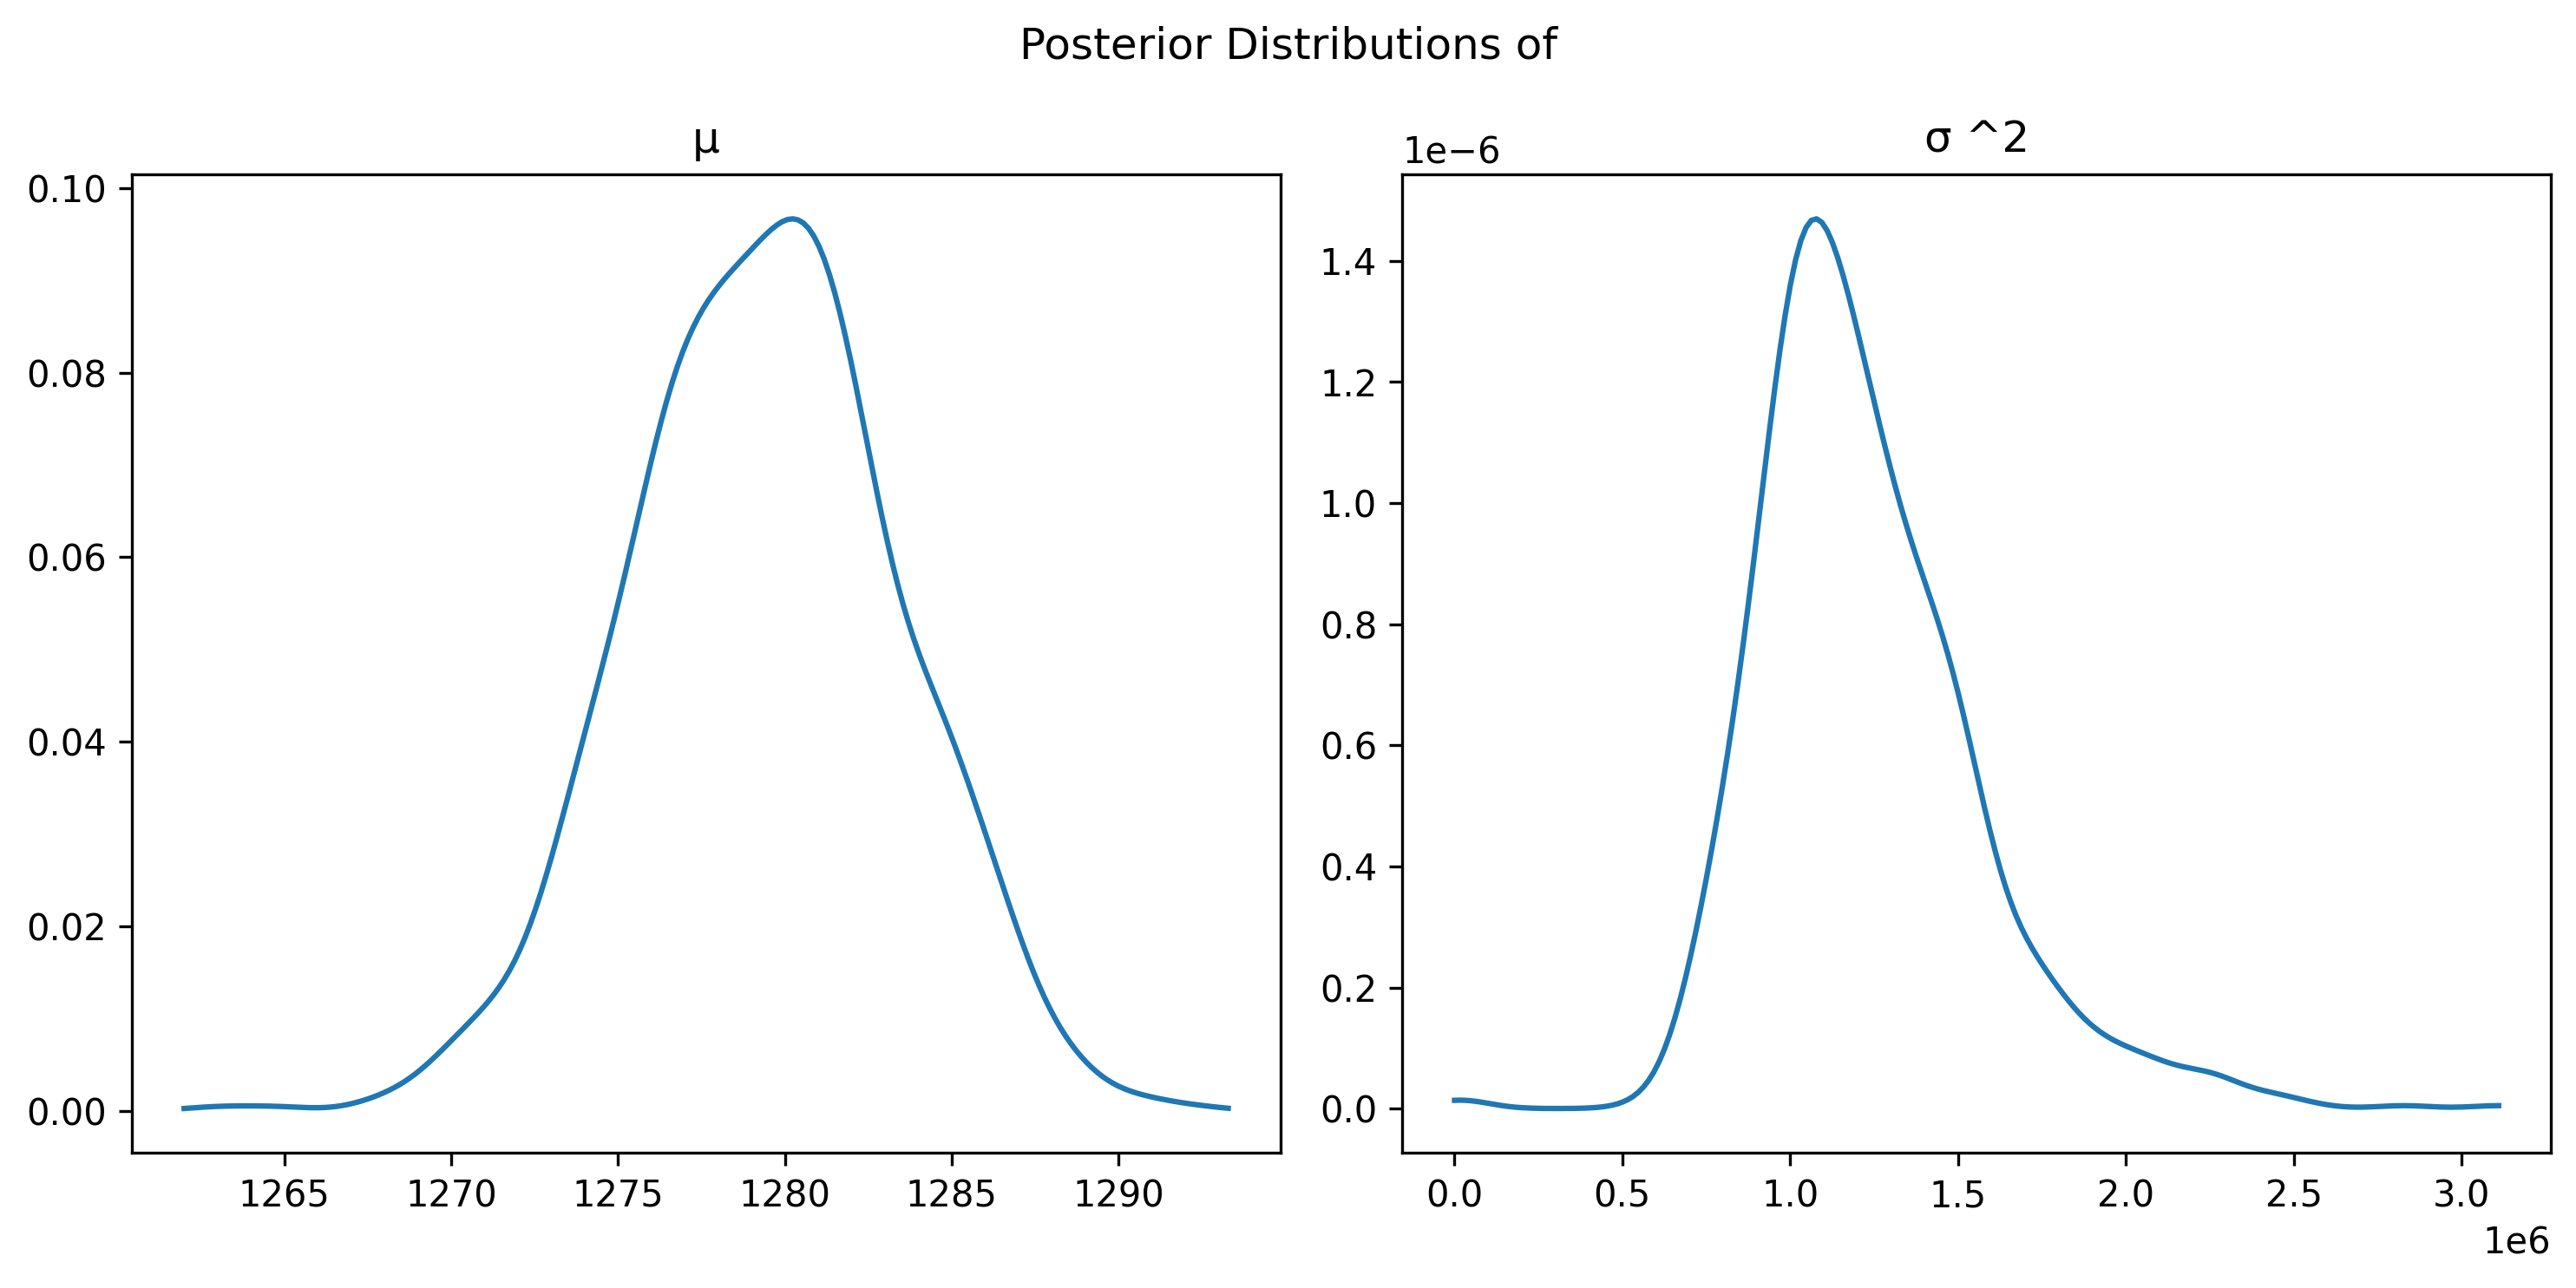

In [28]:
# initialize & find kde for mu
mu_samples = mus
mu_kernel = stats.gaussian_kde(mu_samples)
x = np.linspace(min(mu_samples) - 1, max(mu_samples) + 1, 200)

plt.figure(figsize=(10, 5), dpi=300)

# plot mus
ax1 = plt.subplot(121)
ax1.plot(x, mu_kernel(x))
ax1.set_title('μ')

# initialize & find kde for sig
sig_samples = sigs
sig_kernel = stats.gaussian_kde(sig_samples)
x = np.linspace(min(sig_samples) - 1, max(sig_samples) + 1, 200)

# plot sigs
ax2 = plt.subplot(122)
ax2.plot(x, sig_kernel(x))
ax2.set_title('σ ^2')

plt.suptitle('Posterior Distributions of')
plt.tight_layout()
plt.show()

## Problem 3

Complete the method `LDACGS._initialize()`.



## Problem 4

Complete the method `LDACGS._sweep()`.



## Problem 5

Complete the method `LDACGS.sample()`.


In [35]:
class LDACGS:
    """ Do LDA with Gibbs Sampling. """

    def __init__(self, n_topics, alpha=0.1, beta=0.1):
        """ Initializes attributes n_topics, alpha, and beta. """
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def _buildCorpus(self, filename, stopwords_file=None):
        """ Reads the given filename, and using any provided stopwords,
            initializes attributes vocab and documents. In this lab,
            each line of filename is considered a document.
            
            vocab is a list of terms found in filename.
            
            documents is a list of dictionaries (a dictionary for each 
            document); for dictionary m in documents, each entry is of 
            the form n:v, where v is the index in vocab of the nth word 
            in document m.
        """
        with open(filename, 'r') as infile:  # Create vocab
            doclines = [line.rstrip().lower().split(' ') for line in infile]
        n_docs = len(doclines)
        self.vocab = list({v for doc in doclines for v in doc})

        self.docs = doclines  # Save the documents for toplines()

        if stopwords_file:   # If there are stopwords, remove them from vocab
            with open(stopwords_file, 'r') as stopfile:
                stops = stopfile.read().split()
            self.vocab = [x for x in self.vocab if x not in stops]
            self.vocab.sort()
        
        self.documents = []  # Create documents
        for i in range(n_docs):
            self.documents.append({})
            for j in range(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])


    def _initialize(self):
        """ Initializes attributes n_words, n_docs, the three count matrices, 
            and the topic assignment dictionary topics.
                        
            Note that
            n_topics = K, the number of possible topics
            n_docs   = M, the number of documents being analyzed
            n_words  = V, the number of words in the vocabulary
            
            To do this, you will need to initialize nkm, nkv, and nk 
            to be zero arrays of the correct size.
            Matrix nkm corresponds to n_(k,m,.)
            Matrix nkv corresponds to n_(k,.,v)
            Matrix nk corresponds to n_(k,.,.)
            You will then iterate through each word found in each document.
            In the second of these for-loops (for each word), you will 
            randomly assign k as an integer from the correct range of topics.
            Then, you will increment each of the count matrices by 1, 
            given the values for k, m, and v, where v is the index in 
            vocab of the nth word in document m.
            Finally, assign topics as given.
        """
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)
                
        # Initialize the three count matrices
        # The (k, m) entry of self.nkm is the number of words in document m assigned to topic k
        self.nkm = np.zeros((self.n_topics, self.n_docs))
        # The (k, v) entry of self.nkv is the number of times term v is assigned to topic k
        self.nkv = np.zeros((self.n_topics, self.n_words))
        # The (k)-th entry of self.nk is the number of times topic k is assigned in the corpus
        self.nk = np.zeros(self.n_topics)
        
        # Initialize the topic assignment dictionary
        self.topics = {} # Key-value pairs of form (m,n):k
        
        random_distribution = np.ones(self.n_topics) / self.n_topics
        for m in range(self.n_docs):
            for n in self.documents[m]:
                # Get random topic assignment, i.e. k = ...
                k = np.random.choice(self.n_topics)

                # Increment count matrices
                self.nkm[k, m] += 1
                self.nk[k] += 1
                self.nkv[k, self.documents[m][n]] += 1

                # Store topic assignment, i.e. self.topics[(m,n)]=k
                self.topics[(m, n)] = k
                
                
    def _sweep(self):
        """ Iterates through each word of each document, giving a better
            topic assignment for each word.
            
            To do this, iterate through each word of each document. 
            The first part of this method will undo what _initialize() did
            by decrementing each of the count matrices by 1.
            Then, call the method _conditional() to use the conditional 
            distribution (instead of the uniform distribution used 
            previously) to pick a more accurate topic assignment k.
            Finally, repeat what _initialize() did by incrementing each of
            the count matrices by 1, but this time using the more 
            accurate topic assignment.
        """
        for m in range(self.n_docs):
            for n in self.documents[m]:
                # Retrieve vocab index for n-th word in document m
                j = self.documents[m][n]

                # Retrieve topic assignment for n-th word in document m
                t = self.topics[(m,n)]

                # Decrement count matrices
                self.nkm[t, m] -= 1
                self.nk[t] -= 1
                self.nkv[t, j] -= 1

                # Get conditional distribution
                p_t = self._conditional(m, j)
                
                # Sample new topic assignment
                new_t = np.argmax(np.random.multinomial(1, p_t))

                # Increment count matrices
                self.nkm[new_t, m] += 1
                self.nk[new_t] += 1
                self.nkv[new_t, j] += 1

                # Store new topic assignment
                self.topics[(m, n)] = new_t
                
    def sample(self, filename, burnin=100, sample_rate=10, n_samples=10, stopwords_file=None):
        """ Runs the Gibbs sampler on the given filename. 
        
            The argument filename is the name and location of a .txt 
            file, which can be read in by the provided method _buildCorpus()
            to build the corpus. Stopwords are removed if the stopwords
            argument is provided. Note that in buildCorpus(),
            each line of filename is considered a document.
            
            Initialize attributes total_nkm, total_nkv, and logprobs as
            zero arrays.
            total_nkm and total_nkv will be the sums of every 
            sample_rate-th nkm and nkv matrix respectively.
            logprobs is of length burnin + sample_rate * n_samples
            and will store each log-likelihood after each sweep of 
            the sampler.
            
            Burn-in the Gibbs sampler. After the burn-in, iterate further 
            for n_samples iterations, adding nkm and nkv to total_nkm and 
            total_nkv respectively, at every sample_rate-th iteration.
            Also, compute and save the log-likelihood at each iteration 
            in logprobs using the method _loglikelihood().
        """
        self._buildCorpus(filename, stopwords_file)
        self._initialize()
        
        self.total_nkm = np.zeros((self.n_topics, self.n_docs))
        self.total_nkv = np.zeros((self.n_topics, self.n_words))
        self.logprobs = np.zeros(burnin + sample_rate * n_samples)
        
        for i in range(burnin):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i] = self._loglikelihood()

        for i in range(sample_rate * n_samples):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i+burnin] = self._loglikelihood()
            if not i % sample_rate:
                # Accumulate counts
                self.total_nkm += self.nkm
                self.total_nkv += self.nkv
                
    def _conditional(self, m, v):
        """ Returns the conditional distribution given m and w.
            Called by _sweep(). """
        dist = (self.nkm[:,m] + self.alpha) * (self.nkv[:,v] + self.beta) / (self.nk + self.beta * self.n_words)
        return dist / np.sum(dist)

    def _loglikelihood(self):
        """ Computes and returns the log-likelihood. Called by sample(). """
        lik = 0

        for k in range(self.n_topics):
            lik += np.sum(gammaln(self.nkv[k,:] + self.beta)) - gammaln(np.sum(self.nkv[k,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words * self.beta)

        for m in range(self.n_docs):
            lik += np.sum(gammaln(self.nkm[:,m] + self.alpha)) - gammaln(np.sum(self.nkm[:,m] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics * self.alpha)

        return lik
    
    def _phi(self):
        """ Initializes attribute phi. Called by topterms(). """
        phi = self.total_nkv + self.beta
        self.phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def _theta(self):
        """ Initializes attribute theta. Called by toplines(). """
        theta = self.total_nkm + self.alpha
        self.theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self, n_terms=10):
        """ Returns the top n_terms of each topic found. """
        self._phi()
        vec = np.atleast_2d(np.arange(0, self.n_words))
        topics = []
        for k in range(self.n_topics):
            probs = np.atleast_2d(self.phi[k,:])
            mat = np.append(probs, vec, 0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1, self.n_words - 1 - i])] 
                           for i in range(n_terms)])
        return topics

    def toplines(self, n_lines=5):
        """ Print the top n_lines corresponding to each topic found. """
        self._theta()
        lines = np.zeros((self.n_topics,n_lines))
        for k in range(self.n_topics):
            args = np.argsort(self.theta[:,k]).tolist()
            args.reverse()
            lines[k,:] = np.array(args)[0:n_lines] + 1
        lines = lines.astype(int)

        for k in range(self.n_topics):
            print(f"TOPIC {k + 1}")
            for document in lines[k]:
                print(" ".join(self.docs[document]))

## Problem 6

Create an `LDACGS` object with 20 topics, letting $\alpha$ and $\beta$ be the default values.
Run the Gibbs sampler, with a burn-in of 100 iterations, accumulating 10 samples, only keeping the results of every 10th sweep.
Use `stopwords.txt` as the stopwords file.

Plot the log-likelihoods. How many iterations did it take to burn-in?

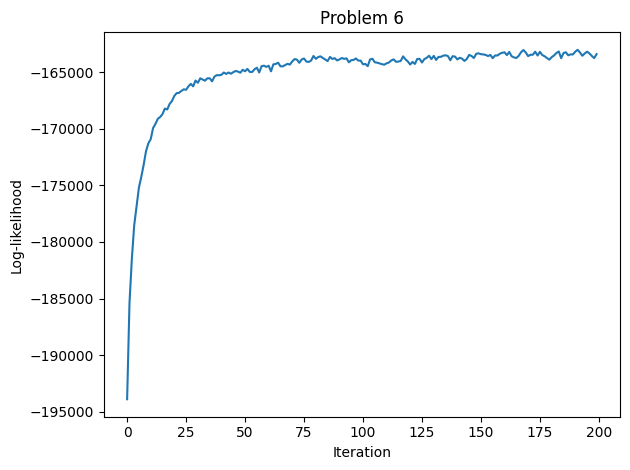

In [37]:
# build model
n_topics = 20
model = LDACGS(n_topics)

# run model
b = 100
model.sample('reagan.txt', stopwords_file='stopwords.txt', burnin=b)

# plot
plt.plot(model.logprobs)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.title('Problem 6')
plt.tight_layout()
plt.show()

Around 25 iterations

## Problem 7

Using the method `LDACGS.topterms()`, examine the topics for Reagan's addresses. 

If `n_topics=20` and `n_samples=10`, you should get the top $10$ words that represent each of the $20$ topics.

Print out all $20$ topics with the associated top $10$ words. For the top $5$ topics, decide what their top $10$ words jointly represent, and come up with a label for them.

In [47]:
terms_set = model.topterms()
for i in range(20):
    words = terms_set[i]
    print(words)
    #print()

['private', 'sector', 'regulations', 'public', 'major', 'task', 'regulatory', 'department', 'initiatives', 'industry']
['war', 'well,', 'build', 'research', 'earth.', 'defense', 'space', 'strategic', 'technology', 'day']
['tax', 'program', 'jobs', 'economic', 'people', 'rates', 'economy', 'incentives', 'jobs,', 'reform']
['congress', 'state', "let's", 'president', 'union', 'address', 'give', 'joint', 'veto', 'work']
["don't", 'hope', 'us.', "they're", 'special', 'turn', 'americans', 'people.', 'people', 'watching']
['bipartisan', "i'm", 'senate', 'join', 'day', 'leader', 'commission', 'house', 'majority', 'congress']
['government', 'federal', 'programs', 'states', 'local', 'people', 'god', 'bless', 'well,', 'you,']
['--', 'america', 'american', 'people', 'great', "we're", 'tonight', 'make', 'nation', "it's"]
['trade', 'world', "america's", 'economic', 'foreign', 'free', 'american', 'policy', 'strengthen', 'develop']
['federal', 'spending', 'budget', 'billion', 'government', 'growth', '

1. Business Regulations
2. Space Technology
3. Tax Reform
4. Government Address
5. Public Sentiment
6. Bipartisan Efforts
7. Government Services
8. National Pride
9. Trade Policy
10. Budget and Growth
11. Peace and Freedom
12. Economic Indicators
13. Soviet Defense
14. Life and Safety
15. Education Commitment
16. Hope for Change
17. Social Change
18. Waste Reduction
19. Social Welfare
20. Formal Address